# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tuning 
- Dogs_and_Cats 데이터셋 이용(컬러, 이진분류)

## VGG-16 Model
- University of Oxford - Visual Geometry Group
- 2014 ILSVRC 2nd Model
- ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

# Import Keras

In [2]:
import keras
keras.__version__

'2.4.3'

# 1. Google Drive Mount

-  'dogs_and_cats_small.zip' 디렉토리를 구글드라이브에 업로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## 1) 마운트 결과 확인

In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


> ## 2) Unzip 'dogs_and_cats_small.zip'

In [4]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

# 2. Image_File Driectory Setting

- train_dir
- valid_dir
- test_dir

In [5]:
train_dir = 'train'       # train 이미지 2000장은 train 디렉터리에 
valid_dir = 'validation'  # valid 이미지 1000장은 valid 디렉터리에
test_dir = 'test'         # test 이미지 1000장은 test 디렉터리에

# Data Preprocessing



> ## 1) ImageDataGenerator( ) & flow_from _directory( )

- Normalization
   - ImageDataGenerator( )
- Resizing & Generator
   - flow_from_directory( )

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255) # 정규화 해서 객체 지정
valid_datagen = ImageDataGenerator(rescale = 1./255) 

train_generator = train_datagen.flow_from_directory( # 디렉터리로부터 데이터 가져오기
                  train_dir,
                  target_size = (150, 150),          # 이미지 크기 일정하게 설정
                  batch_size = 20,                   # 2000장 중에서 한번에 20장씩 부르기
                  class_mode = 'binary')             # 고양이는 0, 강아지는 1로 라벨링

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

# 다중분류는 class_mode = 'categorical'

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 3. Import VGG-16 Model & Some Layers Freezing



> ## 1) conv_base

In [7]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',        # imagenet 데이터셋에 적용됐던 모델
                  include_top = False,         # DNN부분(Classification)은 제외하고 가져온다
                  input_shape = (150, 150, 3)) # 내가 학습시킬 모델 Input_shape 

58892288/58889256 [==============================] - 1s 0us/step


> ## 2) Model Information

In [8]:
conv_base.summary() # DNN파트(3층) 제외한 Layer 13개 가져옴

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> ## 3) 'block5_conv1' Freezing

- Before 'weight' Freezing : 13 Layer 가져왔기 때문에 parameter가 weight, bias합해서 26개임

In [9]:
print('conv_base 동결 전 훈련 가능 가중치의 종류 : ', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류 :  26


- 'weight' Freezing

In [10]:
set_trainable = False # 학습 안되게 Freezing

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
       set_trainable = True            # block5는 학습 가능하게 둔다. 
    
    if set_trainable:
       layer.trainable = True

    else:
       layer.trainable = False         # 나머지 block은 학습 불가능하게 freezing

- After 'weight' Freezing : 10 Layer 는 freezing, 3 Layer는 학습 가능하기 때문에 parameter가 weight, bias합해서 6개임

In [11]:
print('conv_base 동결 후 훈련 가능 가중치의 종류 : ', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류 :  6


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# 5. Keras CNN Modeling with VGG-16 Freezed Layers



> ## 1) Model Define

- 'conv_base'&'Classification' Network  : freeze와 학습가능한 layer 모두 있는 경우
- Dropout Layer

In [13]:
# DNN 
from keras import models, layers
model = models.Sequential()   
model.add(conv_base)

model.add(layers.Flatten())                         
model.add(layers.Dense(256, activation = 'relu')) 
model.add(layers.Dropout(0.4)) 
model.add(layers.Dense(1, activation = 'sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


> ## 2) Model Compile

- 모델 학습방법 설정
   - 이미 학습된 Weight 값을 Tuning
   - 매우 작은 Learning Rate 지정 : 크게 주면 경사하강이 발산할 수 있다
   - optimizers.Adam(lr = 0.000005)

In [15]:
from keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])
# 이진분류

> ## 3) Model Fit

- 약 19분(K80)

In [16]:
%%time

hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,        
                       epochs = 100,             
                       validation_data = valid_generator,
                       validation_steps =50)   

Epoch 1/100
100/100 [==============================] - 47s 118ms/step - loss: 0.7177 - accuracy: 0.5775 - val_loss: 0.4743 - val_accuracy: 0.8210
Epoch 2/100
100/100 [==============================] - 11s 113ms/step - loss: 0.4663 - accuracy: 0.7831 - val_loss: 0.3235 - val_accuracy: 0.8810
Epoch 3/100
100/100 [==============================] - 11s 114ms/step - loss: 0.2899 - accuracy: 0.8849 - val_loss: 0.2535 - val_accuracy: 0.9010
Epoch 4/100
100/100 [==============================] - 11s 114ms/step - loss: 0.2339 - accuracy: 0.9067 - val_loss: 0.2251 - val_accuracy: 0.9090
Epoch 5/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1861 - accuracy: 0.9330 - val_loss: 0.2128 - val_accuracy: 0.9140
Epoch 6/100
100/100 [==============================] - 11s 112ms/step - loss: 0.1545 - accuracy: 0.9457 - val_loss: 0.2025 - val_accuracy: 0.9160
Epoch 7/100
100/100 [==============================] - 11s 113ms/step - loss: 0.1184 - accuracy: 0.9584 - val_loss: 0.1933 -

> ## 4) 학습 결과 시각화 

- Loss Visualization

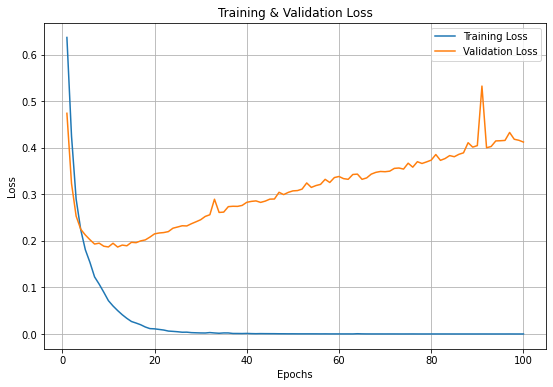

In [17]:
import matplotlib.pyplot as plt
epochs = range(1, len(hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist_dandc.history['loss'])
plt.plot(epochs, hist_dandc.history['val_loss'])
plt.title('Training & Validation Loss')
# plt.ylim(0, 0.4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()
# overfitting 경향이 있다. 

- Accuracy Visualization

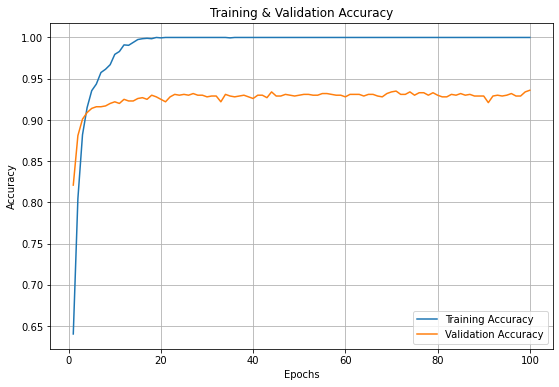

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, len(hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist_dandc.history['accuracy'])
plt.plot(epochs, hist_dandc.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
# plt.ylim(0, 0.4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show() 

> ## 5) Model Evaluate : test data로 돌려보자

- test_generator

In [19]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


- Loss & Accuracy

In [20]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)
                         
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))
# VGG-16 안 썼을 때, accuracy = 0.70700 // VGG-16 썼을 때, accuary = 0.88500 // Fine_tuning : 0.93100
# VGG-16 안 썼을 때, loss = 3.46305 //  VGG-16 썼을 때, loss = 0.84489 // Fine_tuning : 0.41526

50/50 [==============================] - 3s 68ms/step - loss: 0.4153 - accuracy: 0.9310
Loss = 0.41526
Accuracy = 0.93100


# 4. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## 2) Model Save

In [22]:
model.save('/content/drive/My Drive/Colab Notebooks/models/005_dogs_and_cats_fine_tuning.h5')

In [23]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 286352
-rw------- 1 root root   4353288 Mar 19 08:32 001_best_mnist.h5
-rw------- 1 root root     34592 Mar 17 07:32 001_model_iris.h5
drwx------ 2 root root      4096 Mar 19 08:32 002_best_mnist.h6
-rw------- 1 root root  41498896 Mar 23 02:27 002_dogs_and_cats_small.h5
drwx------ 2 root root      4096 Mar 19 08:33 003_best_mnist.h7
-rw------- 1 root root  41499744 Mar 23 06:23 003_dogs_and_cats_small.h5
-rw------- 1 root root  39879700 Mar 23 04:48 003_Logo_Data.h5
-rw------- 1 root root  25199032 Mar 24 05:15 004_dogs_and_cats_feature_extraction.h5
-rw------- 1 root root 140748400 Mar 24 07:28 005_dogs_and_cats_fine_tuning.h5


> ## 3) Model Load

In [24]:
from keras.models import load_model
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/005_dogs_and_cats_fine_tuning.h5')

In [25]:
loss, accuracy = model.evaluate(test_generator)
                         
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))


50/50 [==============================] - 4s 70ms/step - loss: 0.4153 - accuracy: 0.9310
Loss = 0.41526
Accuracy = 0.93100


###
#The End
###